In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/*.wav'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_0*.wav'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(none_files), '개\t',none_files[0])

11 개	 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
21 개	 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def loadSample(files,sample_rate):
    [sample_np, sample_rate] = librosa.load(files[0],sample_rate)
    print(len(sample_np), sample_rate, files[0])
    for f in files[1:]:
        [sample, sample_rate] = librosa.load(f,sample_rate)
        sample_np = np.hstack((sample_np, sample))
    return sample_np, sample_rate

In [5]:
SR = 44100
uav_sample, uav_sample_rate = loadSample(uav_files,SR )
none_sample, none_sample_rate = loadSample(none_files,SR)

print(uav_sample.shape,none_sample.shape )
combine = [[uav_sample,uav_path,uav_sample_rate],[none_sample,none_path,none_sample_rate]]

884736 44100 ../data/phantom/JUNE_01_PHANTOMS/wavs\P1_stationary.wav
884736 44100 ../data/phantom/JUNE_02_BACKGROUND/wavs/background\background_06_02_01.wav
(9732096,) (18579456,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def showFreqTime(combine):
    for sample, filename, _ in combine:
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

In [8]:
#showFreqTime(combine)

In [9]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [10]:
new_sample_rate = combine[0][2]  #/4
combine_prev = combine[:]

combine = []
for samples, path, sample_rate in combine_prev:
    resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))
    combine.append([resampled,path,new_sample_rate])

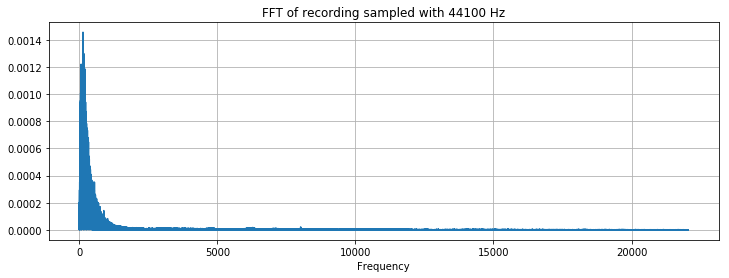

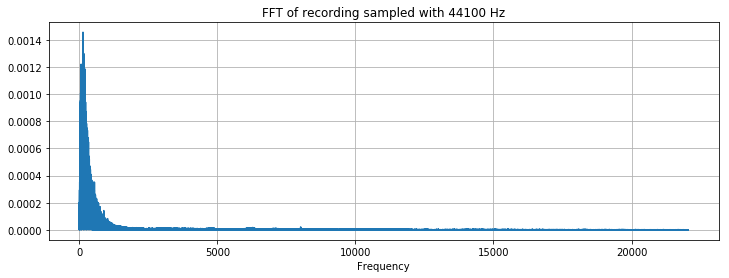

In [11]:
for samples, path, sample_rate in [combine_prev[0],combine[0]]:
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

### Data diffrence

qualiy is diffrence but, the data is almost same.

In [12]:
#ipd.Audio(combine_prev[0][0], rate=combine_prev[0][2])

In [13]:
#ipd.Audio(combine[0][0], rate=combine[0][2])

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

(13, 19009) 44100 190
(13, 36289) 44100 362


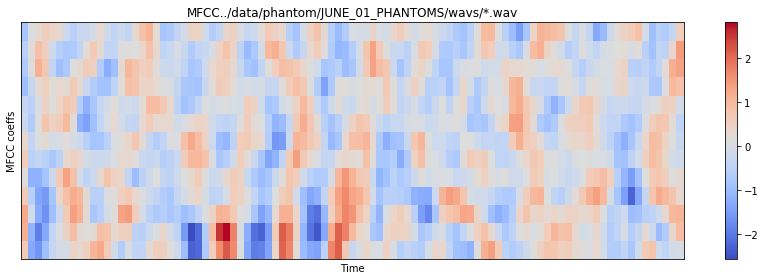

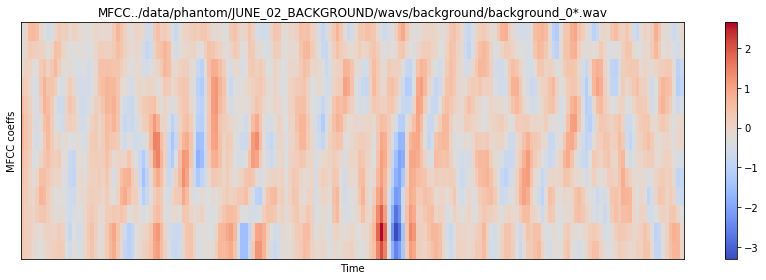

In [14]:
mfcc_combine = []
for sample,path,sample_rate in combine:
    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfcc_combine.append(delta2_mfcc)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC'+path)
    plt.colorbar()
    plt.tight_layout()
    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))

(13, 19009) 44100 190
(13, 36289) 44100 362


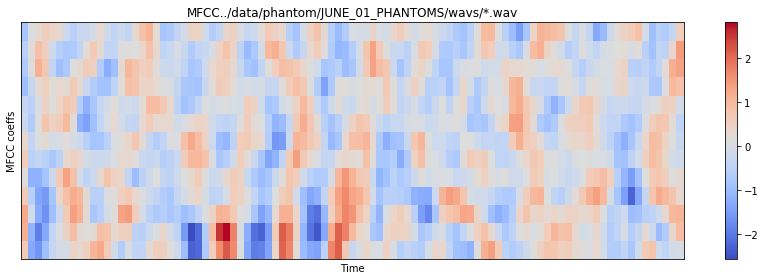

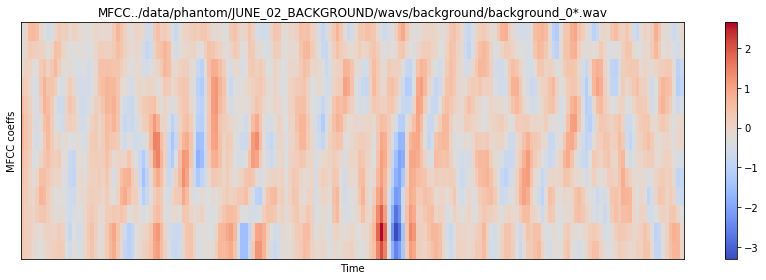

In [15]:
for sample,path,sample_rate in combine_prev:
    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc[ : ,int(delta2_mfcc.shape[1]*0.025) :int(delta2_mfcc.shape[1]*0.030)])
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC'+path)
    plt.colorbar()
    plt.tight_layout()
    print(delta2_mfcc.shape , sample_rate,int(delta2_mfcc.shape[1]*0.01))

In [16]:
for sample,_,sample_rate in combine:
    print(sample_rate)
    
for sample,_,sample_rate in combine_prev:
    print(sample_rate)
    
for mfcc in mfcc_combine:
    print(mfcc.shape)

44100
44100
44100
44100
(13, 19009)
(13, 36289)


## 5. Features normalization with *mean* and *std*

In [17]:
'''
#The mean of UAV and background is diffrent. So, In later I will implement.
mean = np.mean(spectrogram, axis=0)
min = np.min(spectrogram, axis=0)
max = np.max(spectrogram, axis=0)
dom = max-min
spectrogram = (spectrogram - mean) / dom
'''

'\n#The mean of UAV and background is diffrent. So, In later I will implement.\nmean = np.mean(spectrogram, axis=0)\nmin = np.min(spectrogram, axis=0)\nmax = np.max(spectrogram, axis=0)\ndom = max-min\nspectrogram = (spectrogram - mean) / dom\n'

## 6. Stacking of a given number of frames to get temporal information

In [18]:
# or should we give one label to one chunk?
y_uav = np.ones(mfcc_combine[0].shape[1], dtype=int)
y_none =np.zeros(mfcc_combine[1].shape[1], dtype=int)

print(y_uav.shape)
print(y_none.shape)

(19009,)
(36289,)


In [19]:
dataX = np.hstack((mfcc_combine[0], mfcc_combine[1])).T
dataY = np.hstack((y_uav, y_none))
print(dataX.shape, dataY.shape)

(55298, 13) (55298,)


In [20]:
seq_length = 7 #layer
X_hot_list= []
#Y_hot = dataY[seq_length-1:].reshape(len(dataY[seq_length-1:]), 1)
Y_hot_tmp = dataY[seq_length-1:]

for i in range(0, dataX.shape[0] - seq_length+1):
    _x = dataX[i:i + seq_length]
    #if i<10:
        #print(_x, "->", Y_hot_tmp[i])
    X_hot_list.append(_x)

X_hot = np.array(X_hot_list[:])
print(X_hot.shape, Y_hot_tmp.shape)


(55292, 7, 13) (55292,)


In [21]:
Y_hot_tmp.shape

(55292,)

In [22]:
n_labels = Y_hot_tmp.shape[0]
n_unique_labels = 2
Y_hot = np.zeros((n_labels, n_unique_labels))
Y_hot[np.arange(n_labels), Y_hot_tmp] = 1
print(Y_hot.shape)


(55292, 2)


In [23]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_hot, Y_hot, test_size=0.2, random_state=42)

In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(44233, 7, 13) (11059, 7, 13)
(44233, 2) (11059, 2)


In [25]:
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)

In [26]:
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')

# Tensorflow RNN

## Train 

In [27]:
learning_rate = 0.01

# train Parameters
X_dim = 13 #n_dim #X_hot.shape[2]

#seq_length = 7 #X_hot.shape[1]
output_dim = 2 #n_classes #Y_hot.shape[1]

hidden_dim = 2
learning_rate = 0.05

In [28]:

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')


# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))
# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


In [42]:
X_train[100]

array([[-0.39628496, -0.62144761, -0.67045363, -0.51327431, -0.22580119,
        -0.13079387, -0.41387142, -0.8485628 , -0.97185495, -0.52683463,
         0.27756512,  0.91604404,  0.95367433],
       [-0.49295554, -0.70873684, -0.68392831, -0.54946887, -0.3710542 ,
        -0.30866189, -0.41651864, -0.55496004, -0.5272764 , -0.26682336,
         0.1229314 ,  0.46126315,  0.58942088],
       [-0.52680169, -0.57701766, -0.23999211, -0.05814408, -0.1769271 ,
        -0.43141918, -0.54840534, -0.44333483, -0.28223964, -0.25507947,
        -0.3344827 , -0.30705509, -0.0475205 ],
       [-0.54064625, -0.51036594, -0.0079652 ,  0.28041225,  0.21336959,
         0.02696177, -0.05060578, -0.04339585, -0.07969258, -0.18547191,
        -0.30566411, -0.39853766, -0.41100562],
       [-0.02251075,  0.06236967,  0.22727527,  0.29621252,  0.29927966,
         0.36131604,  0.44259844,  0.37813236,  0.15003386, -0.08037171,
        -0.23363127, -0.39375378, -0.54865927],
       [ 0.70862396,  0.935349

In [44]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../models/RNN/my_RNN_model_500'
saver = tf.train.Saver()
training_epochs = 500
# Training step
for learning_rate in [0.02,0.01]:
    test_acc = []
    feed = {lr:learning_rate, X: X_train, Y: y_train}
    for i in range(training_epochs):
        step_loss_prev = step_loss
        _, step_loss = sess.run([train, loss], feed_dict=feed)
        cost_history = np.append(cost_history,step_loss/X_train.shape[0])
        if i%10 == 0:
            print("[step: {}] loss: {}".format(i, step_loss/X_train.shape[0]))
        
        #batch_acc, test_state = sess.run([loss, _states], feed_dict=feed)
    print("Test accuracy: {:.3f}".format(1.0-np.mean(cost_history)))

saver.save(sess, model_path)
sess.close()

[step: 0] loss: 1.0472395468315512
[step: 10] loss: 0.6283063108284539
[step: 20] loss: 0.4325206417578505
[step: 30] loss: 0.38278198863122553
[step: 40] loss: 0.29123017599981915
[step: 50] loss: 0.2002737103802591
[step: 60] loss: 0.16477022245834558
[step: 70] loss: 0.13700126717114486
[step: 80] loss: 0.1224773036922377
[step: 90] loss: 0.1131844062090238
[step: 100] loss: 0.10839903359765334
[step: 110] loss: 0.10459946299990958
[step: 120] loss: 0.10133451472528994
[step: 130] loss: 0.0978724347489431
[step: 140] loss: 0.09547185014935117
[step: 150] loss: 0.09321729843598106
[step: 160] loss: 0.09079111475383198
[step: 170] loss: 0.08871897996122804
[step: 180] loss: 0.0869151608651205
[step: 190] loss: 0.08548341709314879
[step: 200] loss: 0.08432789283100287
[step: 210] loss: 0.0835441734412797
[step: 220] loss: 0.08246094809729161
[step: 230] loss: 0.08207918066686637
[step: 240] loss: 0.08104776614391404
[step: 250] loss: 0.0802423830200303
[step: 260] loss: 0.0796219391930

In [30]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: X_train})
rmse_val = sess.run(rmse, feed_dict={
                    targets: y_train, predictions: test_predict})
print("RMSE: {}".format(rmse_val))

y_ = Y_pred
_true, y_pred = None, None
y_pred = sess.run(tf.argmax(Y_pred,1),feed_dict={X: X_test})
y_true = sess.run(tf.argmax(y_test,1))
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/my_RNN_model_500
RMSE: 0.49575021862983704
(11059,) (11059,)


In [31]:
sess.close()

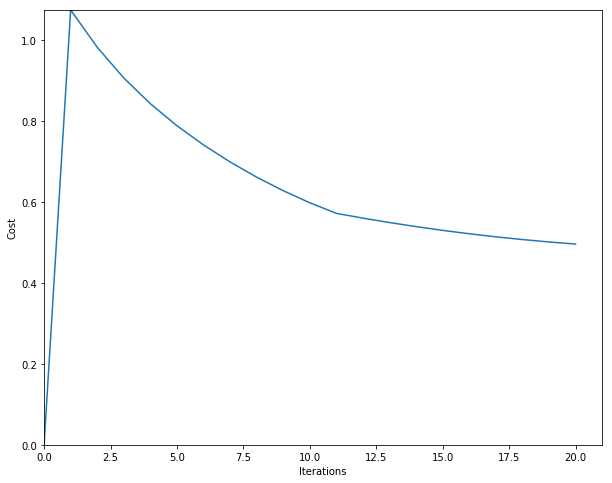

F-Score: 0.656
Accuracy:  0.6558459173523826
             precision    recall  f1-score   support

          0       0.66      0.99      0.79      7240
          1       0.56      0.02      0.03      3819

avg / total       0.62      0.66      0.53     11059

[[7195   45]
 [3761   58]]


In [32]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))